# CITS4404 Practical Project

### Camo Worms!

<div style="margin-left: 0px">
    &nbsp;
    <img src="CamoWorms/velvet-worms.jpg" width=600>
    <br>
    <br>
</div>

### Imports and Global Variables

In [1847]:
# Imports
# pip install imageio matplotlib scikit-learn scipy sympy
import random
import warnings
import numpy as np
import imageio.v3 as iio

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier

from sklearn.metrics.pairwise import euclidean_distances

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images

In [1848]:
# Global Variables
IMAGE_DIR = 'CamoWorms/images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

### Image Preperation

In [1849]:
# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

### Camo Worms and Drawing Them

In [1850]:
class Camo_Worm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))

    def control_points (self):
        return self.bezier.control_points

    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def intermediate_points (self, intervals=None):
        if intervals is None:
            intervals = max(3, int(np.ceil(self.r/8)))
        return self.bezier.point_at_t(np.linspace(0,1,intervals))

    def approx_length (self):
        intermediates = self.intermediate_points()
        eds = euclidean_distances(intermediates,intermediates)
        return np.sum(np.diag(eds,1))

    def colour_at_t(self, t, image):
        intermediates = np.int64(np.round(np.array(self.bezier.point_at_t(t)).reshape(-1,2)))
        colours = [image[point[0],point[1]] for point in intermediates]
        return(np.array(colours)/255)


In [1851]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches([w.patch() for w in worms])
        except TypeError:
            self.add_patches([worms.patch()])

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()

### Random Worms and Clews

In [1852]:
# Example of a random worm. You may do this differently.

    # centre points, angles and colour chosen from uniform distributions
    # lengths chosen from normal distributions with two std parameters passed
    # width chosen from gamma distribution with shape parameter 3 and scale passed

def random_worm (imshape, init_params):
    (radius_std, deviation_std, width_theta) = init_params
    (ylim, xlim) = imshape
    midx = xlim * rng.random()
    midy = ylim * rng.random()
    r = radius_std * np.abs(rng.standard_normal())
    theta = rng.random() * np.pi
    dr = deviation_std * np.abs(rng.standard_normal())
    dgamma = rng.random() * np.pi
    colour = rng.random()
    width = width_theta * rng.standard_gamma(3)
    return Camo_Worm(midx, midy, r, theta, dr, dgamma, width, colour)

In [1853]:
# Initialise a random clew

def initialise_clew (size, imshape, init_params):
    clew = []
    for i in range(size):
        clew.append(random_worm(imshape, init_params))
    return clew

&copy; Cara MacNish, UWA, 2024

### Cost Function

In [1854]:
class CostFunction:
    def __init__(self, image, weights):
        self.image = image
        self.weights = weights

    def coverage_cost(self, worm):
        pass

    def smoothness_cost(self, worm):
        '''
        Considering the worm's curvature and length with respect to 
        the layer changes (i.e., intensity changes).
        '''
        total_smoothness_cost = 0
        detail = 100
        ideal_lengths = {"short": 70, "mid": 100, "long": 150}
        # ideal_curves = {"no-edge": 200, "slight-edge": 100, "edge": 10}
        path_intensity = []

        # Get 100 points along the worm's path
        path = np.array(worm.intermediate_points(detail))
        # p0 = path[0]
        # p1 = path[-1]

        # Calculate color adaptation cost for each point
        for x, y in path:
            # Ensure coordinates are within the image bounds
            x = max(0, min(int(x), self.image.shape[1] - 1))
            y = max(0, min(int(y), self.image.shape[0] - 1))
            # Sort intensity at each point
            pixel_colour = self.image[y, x].astype(float) / 255
            path_intensity.append(pixel_colour)

        # Calculate the intesity gradients and magnitudes
        gradients = np.zeros(len(path_intensity))
        gradients = abs(np.diff(path_intensity))
        magnitude = sum(gradients)
        # print("################# NEW WORM #################")
        # print(f"path_intensity:{path_intensity}")
        # print(f"gradient:{gradients}")
        # print(f"magnitude:{magnitude}")
        # print(f"-mag: {sum(np.diff(path_intensity))}")
        # drawing = Drawing(self.image)
        # drawing.add_worms(worm)
        # drawing.show()

        # Get the worm's features
        worm_curvature = worm.dr
        worm_curve_direct = worm.dgamma
        worm_orientation = worm.theta
        worm_length = worm.approx_length()

        # Edge detection
        if (magnitude >= 2):
            # Large change in intensity in the worm
            # The worm is ontop of multiple layers/edges; it should be straighter or rotated
            total_smoothness_cost += abs(ideal_lengths["short"]-worm_length)/ideal_lengths["short"]
            total_smoothness_cost += abs(worm_curvature/300)
            total_smoothness_cost += abs(worm_orientation/1.5)
        elif (1 <= magnitude < 2):
            # Could be a minor edge, we want the worm to be straighter
            total_smoothness_cost += abs(ideal_lengths["mid"]-worm_length)/ideal_lengths["mid"]
            total_smoothness_cost += abs((worm_orientation/magnitude) / (2*np.pi))
            total_smoothness_cost += abs(worm_curve_direct/magnitude)
        else:
            # Small or no change in intensity in the worm
            # The worm should just grow longer, it has room!
            total_smoothness_cost += abs(ideal_lengths["long"]- worm_length)/ideal_lengths["long"]
            total_smoothness_cost += (worm_curvature*magnitude)
        print(total_smoothness_cost)
        return total_smoothness_cost 

    def detail_preservation_cost(self, worm):
        pass

    def colour_adaptation_cost(self, worm):
        # Initialize total colour cost
        total_colour_cost = 0

        # Get all points along the worm's path
        num_points = max(int(worm.approx_length() / (worm.width)), 1)
        path = worm.intermediate_points(num_points)

        # Get worm's colour and width
        colour = worm.colour
        width = int(worm.width)
        checked_points = []
        total_colour_cost_added = 0

        # Calculate colour adaptation cost for each point
        for x, y in path:
            # Ensure coordinates are within the image bounds
            x = max(0, min(int(x), self.image.shape[1] - 1))
            y = max(0, min(int(y), self.image.shape[0] - 1))

            for dx in range(-width, width + 1):
                for dy in range(-width, width + 1):
                    if (dx, dy) not in checked_points:
                        checked_points.append((dx, dy))
                        # Check coordinates are within the image bounds
                        nx = max(0, min(int(x + dx), self.image.shape[1] - 1))
                        ny = max(0, min(int(y + dy), self.image.shape[0] - 1))

                        # Calculate the distance between current point and the worm's closest intermediate point
                        distance = np.sqrt((x - nx) ** 2 + (y - ny) ** 2)

                        # If the distance is less than the worm's width, calculate the color difference
                        if distance <= width:
                            # Calculate colour difference between worm and image at each point
                            image_colour = self.image[ny, nx].astype(float) / 255
                            colour_difference = np.linalg.norm(colour - image_colour)
                            
                            # Accumulate colour adaptation cost
                            total_colour_cost += colour_difference
                            total_colour_cost_added += 1

        # ------------------Testing ---------------------
        # Change the return value to the value below -- just for testing purposes                    
        return (1 - colour) + total_colour_cost / total_colour_cost_added
        # return total_colour_cost / total_colour_cost_added

    def efficiency_cost(self, worm):
        pass

    def evaluate(self, worm):
        # Evaluate the total cost
        coverage_cost = 0 #self.coverage_cost(worm)
        smoothness_cost = self.smoothness_cost(worm)
        detail_cost = 0 #self.detail_preservation_cost(worm)
        colour_cost = self.colour_adaptation_cost(worm)
        efficiency_cost = 0 #self.efficiency_cost(worm)
        total_cost = (self.weights['coverage'] * coverage_cost +
                      self.weights['smoothness'] * smoothness_cost +
                      self.weights['detail'] * detail_cost +
                      self.weights['colour'] * colour_cost +
                      self.weights['efficiency'] * efficiency_cost)

        return total_cost

### Genetic Algorithm

In [1855]:
class GeneticAlgorithm:
    def __init__(self, image, population_size, crossover_rate, mutation_rate, weights):
        self.image = image
        self.population_size = population_size 
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.weights = weights

    def initialise_population(self, image_shape, init_params):
        population = [random_worm(image_shape, init_params) for _ in range(self.population_size)]
        return population

    def select_parents(self, population):
        # Select parents based on fitness
        tournament_size = 3
        parents = []
        for _ in range(self.population_size):
            # ------------ Replace with Different Function------------
            tournament_indices = np.random.choice(range(len(population)), tournament_size, replace=False)
            tournament = [population[i] for i in tournament_indices]
            winner = random.choice(tournament)
            parents.append(winner)
        return parents

    def crossover(self, parent1, parent2):
        # Crossover parents to create offspring
        params = ['x', 'y', 'r', 'theta', 'dr', 'dgamma', 'width', 'colour']

        # Get other parameters from parents
        p1 = np.zeros(len(params))
        p2 = np.zeros(len(params))
        for i, param in enumerate(params):
            if random.random() < self.crossover_rate:
                p1[i] = getattr(parent2, param)
                p2[i] = getattr(parent1, param)
            else:
                p1[i] = getattr(parent1, param)
                p2[i] = getattr(parent2, param)
        
        return p1, p2

    def mutate(self, worm_params, init_params):
        # Mutate offspring
        # Randomly select any parameters of the worm and mutate it
        params = ['x', 'y', 'r', 'theta', 'dr', 'dgamma', 'width', 'colour']
        (radius_std, deviation_std, width_theta) = init_params
        for i, param in enumerate(params):
            if random.random() < self.mutation_rate:
                if param == 'x':
                    worm_params[i] = self.image.shape[1] * rng.random()
                elif param == 'y':
                    worm_params[i] = self.image.shape[0] * rng.random()
                elif param == 'r':
                    worm_params[i] = radius_std * np.abs(rng.standard_normal())
                elif param == 'theta':
                    worm_params[i] = rng.random() * np.pi
                elif param == 'dr':
                    worm_params[i] = deviation_std * np.abs(rng.standard_normal())
                elif param == 'dgamma':
                    worm_params[i] = rng.random() * np.pi
                elif param == 'width':
                    worm_params[i] = width_theta * rng.standard_gamma(3)
                elif param == 'colour':
                    worm_params[i] = rng.random()
        return worm_params
    
    def run(self, max_generations, init_params):
        # Initialize population
        population = self.initialise_population(self.image.shape, init_params)
        cost = CostFunction(image, self.weights)

         # ------------ Add Cost_function to offspring------------
        for generation in range(max_generations):
            # Select parents
            parents = self.select_parents(population)

            # Create offspring through crossover
            offspring = []
            for i in range(0, self.population_size, 2):
                child_param1, child_param2 = self.crossover(parents[i], parents[i+1])
                child_param1= self.mutate(child_param1, init_params)
                child_param2= self.mutate(child_param2, init_params)
                child1 = Camo_Worm(*child_param1)
                child2 = Camo_Worm(*child_param2)
                offspring.extend([child1, child2])
            
            # add parents and offspring together
            new_population = population + offspring

            # Evaluate the cost of each worm in the new population
            pop_cost = [cost.evaluate(worm) for worm in new_population]
            # Get the indices of worms sorted by their costs in ascending order
            sorted_indices = sorted(range(len(pop_cost)), key=lambda k: pop_cost[k])
            sorted_population = [new_population[i] for i in sorted_indices]

            # Replace old population with new population
            population = sorted_population[:self.population_size]
 
        return population

### Run Genetic Algorithm

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


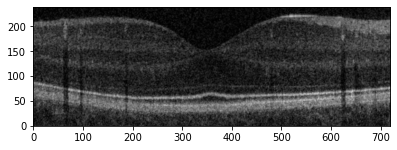

2.115343156654361
3.750915749364179
5.329457669865031
2.0996000749635955
6.6830820318981505
1.4711039043234218
1.676678925255453
0.7237510154612605
5.478124529125286
1.2416441806352532
2.0591781346659395
1.663786081877539
2.1679711444310312
0.535931048330949
1.621626646105301
1.626867586859717
0.9370480910801984
1.0010695185981493
1.374389471293176
2.792290475964812
0.9368404968777393
1.453258854485597
11.421577341566273
2.1278396114090876
30.681150175807463
1.1484716191484785
1.9559160948048828
28.62399883626827
2.6232537017194546
2.120453419472468
1.937975699392024
0.6316849193194494
1.1150124308876261
1.0966577539244509
1.738899840964329
2.6785532779086836
0.5947184069321196
1.816305712604553
1.2373002253045133
0.6553183538546798
1.018495114039724
1.2956722056348067
2.6070942361575673
1.5013760903345301
2.2035427167884993
2.553702764441793
1.5741662360135562
1.7125647445516416
3.501158506535668
2.2174257663653334
1.1655198745730837
0.8878661640864773
1.277855948090956
1.900470235868

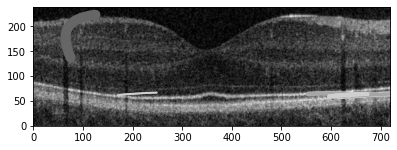

In [1856]:
# Load in OCT scan
image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

# Define parameters for the Genetic Algorithm
population_size = 50 # Number of worms in the population ---- to be adjusted
crossover_rate = 0.5 # Probability of crossover
mutation_rate = 0.1 # Probability of mutation`

# Define weights --- to be adjusted/required?
weights = {'coverage': 1, 'smoothness': 1, 'detail': 1, 'colour': 1, 'efficiency': 1}

# Create an instance of the GeneticAlgorithm class
genetic_algorithm = GeneticAlgorithm(image, population_size, crossover_rate, mutation_rate, weights)

# Define initial parameters for the worms
init_params = (40, 30, 1)  # Example parameters, adjust as needed

# Define the maximum number of generations
max_generations = 20
clew = genetic_algorithm.run(max_generations, init_params)

# Display the optimized population of worms
drawing = Drawing(image)
for worm in clew:
    drawing.add_worms(worm)


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Testing cost function for a single worm
print(f"Light = {image[63, 550].astype(float)}, pixel = {image[63, 550].astype(float)/255}" )

worm_test = Camo_Worm(100, 180, 50, np.pi/3, 70, np.pi/2, 10, 0.4)
print(np.pi/2, np.pi/9)
worm_test2 = Camo_Worm(200, 160, 50, np.pi/6, 70, np.pi/1, 8, 0.6)
test = ['x', 'y', 'r', 'theta', 'dr', 'dgamma', 'width', 'colour']
print(worm_test)
cost = CostFunction(image, weights)
c_c = cost.evaluate(worm_test)
print(c_c)
drawing.add_worms(worm_test)

# drawing.add_dots(worm_test.intermediate_points(300), radius=2, color='green')
# drawing.add_dots(worm_test.control_points(),color='orange')
print(f'length:{worm_test.approx_length()}')
print(f"control points:\n{worm_test.control_points()}")

drawing.show()